In [3]:
###
#not to be run again, this was just to get the movie_title's from the movie_id's since we won't be using
#the other details about movies
###

# f_r = "./ml-100k/u.item"
# f_w = "./ml-100k/u.item_modified"
# with open(f_r) as r_file, open(f_w, 'w') as w_file:
#     data_r = r_file.read().splitlines()
#     for l in data_r:
#         line = l.split('|')
#         w_file.write(line[0] + '|' + line[1] + '\n')


In [35]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch.optim import SGD, Adam

import numpy as np
import pandas as pd 
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from itertools import product

In [2]:
cols = ["user_id", "movie_id", "rating"]
#see http://files.grouplens.org/datasets/movielens/ml-100k-README.txt
n_users, n_items, n_ratings = 943, 1682, 100000     #each user is unique and has rated at least 20 movies, and the movies have been rated by enough users  
train_data = pd.read_csv("./ml-100k/u1.base", sep='\t', names=cols, usecols=cols).astype(int)
test_data = pd.read_csv("./ml-100k/u1.test", sep='\t', names=cols, usecols=cols).astype(int)
# train_data.head(2000)
# test_data.head()

train_data[["rating"]] = preprocessing.MinMaxScaler().fit_transform(train_data[["rating"]].values.astype(float))
test_data[["rating"]] = preprocessing.MinMaxScaler().fit_transform(test_data[["rating"]].values.astype(float))

train_data.head(1500)

,user_id,movie_id,rating
0,1,1,1.00
1,1,2,0.50
2,1,3,0.75
3,1,4,0.50
4,1,5,0.50
...,...,...,...
1495,18,134,1.00
1496,18,137,1.00
1497,18,142,0.75
1498,18,143,0.75


In [3]:
#we didn't use the movie_titles in the end, because we didn't have time to develop an app for recommending items, but it would have been nice
cols = ["movie_id", "movie_title"]
movie_data = pd.read_csv("./ml-100k/u.item_modified", sep='|', names=cols, usecols=cols, encoding='latin-1')
# movie_data.head()
train_data_movie = pd.merge(train_data, movie_data, how='left')
train_data_movie.head(1500)

,user_id,movie_id,rating,movie_title
0,1,1,1.00,Toy Story (1995)
1,1,2,0.50,GoldenEye (1995)
2,1,3,0.75,Four Rooms (1995)
3,1,4,0.50,Get Shorty (1995)
4,1,5,0.50,Copycat (1995)
...,...,...,...,...
1495,18,134,1.00,Citizen Kane (1941)
1496,18,137,1.00,Big Night (1996)
1497,18,142,0.75,Bedknobs and Broomsticks (1971)
1498,18,143,0.75,"Sound of Music, The (1965)"


In [23]:
#utilities
#function used to get the minibatches
def iter_minibatches(train_data, batch_size, shuffle=True):
    users, items, ratings = train_data["user_id"], train_data["movie_id"], train_data["rating"]
    if shuffle:
        indices = np.arange(users.shape[0])
        np.random.shuffle(indices)
    for idx in range(0, users.shape[0] - batch_size + 1, batch_size):
        slc = indices[idx:idx + batch_size] if shuffle else slice(idx, idx + batch_size)
        yield users[slc], items[slc], ratings[slc]

#function used to train the models
def train(n_epochs, train_data, batch_size, optimizer, loss_func, model):
    model.train()
    avg_losses = []
    for e in range(n_epochs):
        losses = []
        for users, items, ratings in iter_minibatches(train_data, batch_size):
            users = Variable(torch.LongTensor(users.values)).cuda()
            items = Variable(torch.LongTensor(items.values)).cuda()
            ratings = Variable(torch.FloatTensor(ratings.values)).cuda()
            optimizer.zero_grad()
            predictions = model(users, items)
            train_loss = loss_func(predictions, ratings)
            losses.append(train_loss.item())
            train_loss.backward()
            optimizer.step()
        avg_loss = sum(losses)/len(losses)
#         print("epoch", e, ":", avg_loss)
        avg_losses.append(avg_loss)
    state = model.state_dict()
    return avg_losses, state

#function used to evaluate the models
def evaluate(model, test_data):
    with torch.no_grad():
        model.eval()
        users = Variable(torch.LongTensor(test_data["user_id"].values)).cuda()
        items = Variable(torch.LongTensor(test_data["movie_id"].values)).cuda()
        test_pred = model(users, items)
#         print(test_pred.cpu().numpy())
        return test_pred

def show_plots(mf_data, dn_data, x_s, labels):
    fig = plt.figure()
    plt.plot(x_s, mf_data, label = "MF")
    plt.plot(x_s, dn_data, label = "DN")
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
#     plt.xlim(0, mf_data[-1][0])
    plt.title(labels[2])
    plt.legend(loc = "best")
    plt.show()
    fig.savefig("./graphs/" + labels[2] + '.png', format='png')
    


In [5]:
class MatrixFacto(nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
        self.users_factors = nn.Embedding(n_users, n_factors)
        self.items_factors = nn.Embedding(n_items, n_factors)
        
    def forward(self, user, item):
        return (self.users_factors(user) * self.items_factors(item)).sum(1)
            
    def predict(self, user, item):
        self.forward(user, item)

In [6]:
class DN(nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):  #n_factors is also hyperparam #see https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf
        super().__init__()
        self.users_factors = nn.Embedding(n_users, n_factors)
        self.items_factors = nn.Embedding(n_items, n_factors)
        self.L1 = nn.Linear(n_factors*2, n_factors)
        self.L2 = nn.Linear(n_factors, n_factors)
        self.L3 = nn.Linear(n_factors, 1)
        self.drop = nn.Dropout()
        
    def forward(self, user, item):
        x = torch.cat([self.users_factors(user), self.items_factors(item)], dim=1)
        x = F.relu(self.L1(x))
        x = self.drop(x)
        x = F.relu(self.L2(x))
        x = self.drop(x)
        return self.L3(x)
            
    def predict(self, user, item):
        self.forward(user, item)

In [74]:
n_factors = 20
batch_size = 128

n_epochs = 50
avg_losses = {}
states = {}
metrics = {}
models = {"MatrixFacto": MatrixFacto(n_users, n_items, n_factors), "DN": DN(n_users, n_items, n_factors)}
losses = {"MSELoss": nn.MSELoss(), "L1Loss": nn.L1Loss()}

for model_ in models:
    for l in losses:
        model = models[model_]
        optimizer = SGD(model.parameters(), lr=0.001)
        model.cuda()
        avg_ = []
        n_iters = 10
        loss_func = losses[l]
        for i in range(n_iters):
            avg_losses_i, state = train(n_epochs, train_data, batch_size, optimizer, loss_func, model)
            avg_.append(avg_losses_i)
        avg_losses_ = [None] * n_epochs
        for i in range(n_epochs):
            avg = 0
            for j in range(n_iters):
                avg += avg_[j][i]
            avg_losses_[i] = avg / n_iters
#         print(avg_losses_)            
        avg_losses[model_ + "_SGD_" + l] = avg_losses_
        states[model_ + "_SGD_" + l] = state
        test_pred = evaluate(model, test_data)
        metrics[model_ + "_SGD_" + l] = [mean_squared_error(test_pred.cpu().numpy(), test_data["rating"].values), 
                   mean_absolute_error(test_pred.cpu().numpy(), test_data["rating"].values)]
        print('-'*50)
    

# torch.save(states[-1], "./model_state_preprocessed_Adam_MSE.pth")

epoch 0 : 21.053969694519044
epoch 1 : 20.831495652770997
epoch 2 : 20.612967529296874
epoch 3 : 20.398253506469725
epoch 4 : 20.187297953796385
epoch 5 : 19.979980278015137
epoch 6 : 19.776206701660158
epoch 7 : 19.575915104675293
epoch 8 : 19.379024282836912
epoch 9 : 19.18543723449707
epoch 10 : 18.99507763519287
epoch 11 : 18.807878257751465
epoch 12 : 18.623762652587892
epoch 13 : 18.442653874206542
epoch 14 : 18.26449883880615
epoch 15 : 18.089228463745116
epoch 16 : 17.916752043151856
epoch 17 : 17.74704100494385
epoch 18 : 17.580003843688964
epoch 19 : 17.415608694458008
epoch 20 : 17.253770672607423
epoch 21 : 17.09446026611328
epoch 22 : 16.937606455993652
epoch 23 : 16.783162030029295
epoch 24 : 16.631065028381347
epoch 25 : 16.481277262878418
epoch 26 : 16.333761018371582
epoch 27 : 16.188447265625
epoch 28 : 16.045289070129396
epoch 29 : 15.904266760253906
epoch 30 : 15.765299015808106
epoch 31 : 15.628388700866699
epoch 32 : 15.493453430175782
epoch 33 : 15.36046979522705

C:\Users\sajsa\anaconda3\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0 : 0.2530048536300659
epoch 1 : 0.11297468888759613
epoch 2 : 0.09795149326324464
epoch 3 : 0.09111199123859405
epoch 4 : 0.08714410153627396
epoch 5 : 0.08470295256376266
epoch 6 : 0.08319654482007027
epoch 7 : 0.08202576349973678
epoch 8 : 0.08127522342801094
epoch 9 : 0.08067617354393006
epoch 10 : 0.08024288470149041
epoch 11 : 0.07990696952342988
epoch 12 : 0.07967012988328934
epoch 13 : 0.07946035281419754
epoch 14 : 0.07930365816950798
epoch 15 : 0.07917409924864768
epoch 16 : 0.07906756545305252
epoch 17 : 0.07898206441402435
epoch 18 : 0.0788928180873394
epoch 19 : 0.07882969291210175
epoch 20 : 0.0787651340007782
epoch 21 : 0.07871293692588806
epoch 22 : 0.07866089506745338
epoch 23 : 0.0786322308421135
epoch 24 : 0.07858890459537506
epoch 25 : 0.07856076148748398
epoch 26 : 0.07854051956534386
epoch 27 : 0.07851333721280097
epoch 28 : 0.07848939229846001
epoch 29 : 0.07846649208068848
epoch 30 : 0.07845228385925293
epoch 31 : 0.07843584907054901
epoch 32 : 0.078415850

C:\Users\sajsa\anaconda3\lib\site-packages\torch\nn\modules\loss.py:88: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


epoch 0 : 0.2303202168226242
epoch 1 : 0.22545911169052124
epoch 2 : 0.22425504932403564
epoch 3 : 0.22343055787086485
epoch 4 : 0.22296357233524322
epoch 5 : 0.2228001259326935
epoch 6 : 0.2227823938846588
epoch 7 : 0.2227570528268814
epoch 8 : 0.22274400057792665
epoch 9 : 0.22272556743621827
epoch 10 : 0.2227049681186676
epoch 11 : 0.2226871584892273
epoch 12 : 0.22266898646354674
epoch 13 : 0.22265367336273192
epoch 14 : 0.2226410178422928
epoch 15 : 0.22263435277938842
epoch 16 : 0.22263045899868011
epoch 17 : 0.22262187225818633
epoch 18 : 0.2226193661928177
epoch 19 : 0.22261296269893646
epoch 20 : 0.22260550467967988
epoch 21 : 0.22260312936306
epoch 22 : 0.22260487508773805
epoch 23 : 0.2226054583311081
epoch 24 : 0.2226034341096878
epoch 25 : 0.22260281562805176
epoch 26 : 0.2226038860797882
epoch 27 : 0.22260358734130858
epoch 28 : 0.22260443305969238
epoch 29 : 0.22260412282943726
epoch 30 : 0.22260257465839386
epoch 31 : 0.22260320706367492
epoch 32 : 0.2226027338027954
ep

In [75]:
print(avg_losses)
print(metrics)

{'MatrixFacto_SGD_MSELoss': [21.053969694519044, 20.831495652770997, 20.612967529296874, 20.398253506469725, 20.187297953796385, 19.979980278015137, 19.776206701660158, 19.575915104675293, 19.379024282836912, 19.18543723449707, 18.99507763519287, 18.807878257751465, 18.623762652587892, 18.442653874206542, 18.26449883880615, 18.089228463745116, 17.916752043151856, 17.74704100494385, 17.580003843688964, 17.415608694458008, 17.253770672607423, 17.09446026611328, 16.937606455993652, 16.783162030029295, 16.631065028381347, 16.481277262878418, 16.333761018371582, 16.188447265625, 16.045289070129396, 15.904266760253906, 15.765299015808106, 15.628388700866699, 15.493453430175782, 15.36046979522705, 15.229404730224608, 15.100209281921387, 14.972847778320313, 14.847283647155761, 14.72349469909668, 14.601436817932129, 14.48107592163086, 14.362370944213867, 14.245311617279052, 14.129833712768555, 14.015940653991699, 13.90358123474121, 13.792745635986329, 13.683383503723144, 13.575469116210938, 13.

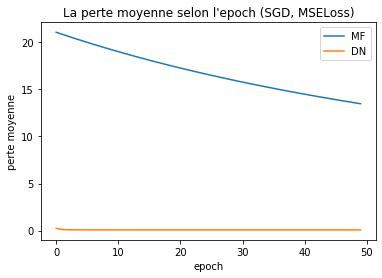

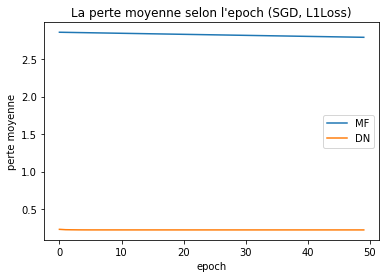

In [33]:
n_epochs = len(avg_losses["MatrixFacto_SGD_MSELoss"])
x_s = [i for i in range(n_epochs)]
show_plots(avg_losses["MatrixFacto_SGD_MSELoss"], avg_losses["DN_SGD_MSELoss"], x_s, ["epoch", "perte moyenne", "La perte moyenne selon l'epoch (SGD, MSELoss)"])
show_plots(avg_losses["MatrixFacto_SGD_L1Loss"], avg_losses["DN_SGD_L1Loss"], x_s, ["epoch", "perte moyenne", "La perte moyenne selon l'epoch (SGD, L1Loss)"])

In [83]:
n_factors = 20
batch_size = 128

n_epochs = 50
avg_losses_adam = {}
states_adam = {}
metrics_adam = {}
models = {"MatrixFacto": MatrixFacto(n_users, n_items, n_factors), "DN": DN(n_users, n_items, n_factors)}
losses = {"MSELoss": nn.MSELoss(), "L1Loss": nn.L1Loss()}

for model_ in models:
    for l in losses:
        model = models[model_]
        optimizer = Adam(model.parameters(), lr=0.001)
        model.cuda()
        avg_ = []
        n_iters = 10
        loss_func = losses[l]
        for i in range(n_iters):
            avg_losses_i, state = train(n_epochs, train_data, batch_size, optimizer, loss_func, model)
            avg_.append(avg_losses_i)
        avg_losses_ = [None] * n_epochs
        for i in range(n_epochs):
            avg = 0
            for j in range(n_iters):
                avg += avg_[j][i]
            avg_losses_[i] = avg / n_iters
#         print(avg_losses_)            
        avg_losses_adam[model_ + "_Adam_" + l] = avg_losses_
        states_adam[model_ + "_Adam_" + l] = state
        test_pred = evaluate(model, test_data)
        metrics_adam[model_ + "_Adam_" + l] = [mean_squared_error(test_pred.cpu().numpy(), test_data["rating"].values), 
                   mean_absolute_error(test_pred.cpu().numpy(), test_data["rating"].values)]
        print('-'*50)

epoch 0 : 18.33378876953125
epoch 1 : 14.413975028991699
epoch 2 : 11.418426676177978
epoch 3 : 9.10276570892334
epoch 4 : 7.290267041015625
epoch 5 : 5.859876419830322
epoch 6 : 4.72393437461853
epoch 7 : 3.8192803817749024
epoch 8 : 3.098384078979492
epoch 9 : 2.5243771909713746
epoch 10 : 2.068568662071228
epoch 11 : 1.7063698741912843
epoch 12 : 1.4185018747329712
epoch 13 : 1.1888890617370604
epoch 14 : 1.0049608078956604
epoch 15 : 0.855635751914978
epoch 16 : 0.7316529635429382
epoch 17 : 0.6258459560394287
epoch 18 : 0.5327112869262696
epoch 19 : 0.4489323290348053
epoch 20 : 0.373633712387085
epoch 21 : 0.30762681739330294
epoch 22 : 0.2518017887830734
epoch 23 : 0.20628718775510788
epoch 24 : 0.16994985133409501
epoch 25 : 0.14160473284721375
epoch 26 : 0.11966110991239548
epoch 27 : 0.10267960604429245
epoch 28 : 0.08954281192421913
epoch 29 : 0.07943375690579414
epoch 30 : 0.07159591835141182
epoch 31 : 0.0655304567694664
epoch 32 : 0.06071231521964073
epoch 33 : 0.05694154

C:\Users\sajsa\anaconda3\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0 : 0.12279825830459595
epoch 1 : 0.08564505515098572
epoch 2 : 0.08034111090898514
epoch 3 : 0.07871074202060699
epoch 4 : 0.07831434687972069
epoch 5 : 0.07825675708651543
epoch 6 : 0.07823144624829292
epoch 7 : 0.07824067962765693
epoch 8 : 0.07823040981292724
epoch 9 : 0.078240814858675
epoch 10 : 0.07822055807709694
epoch 11 : 0.07821523087024689
epoch 12 : 0.07820340669751168
epoch 13 : 0.07822275068163871
epoch 14 : 0.07821230232119561
epoch 15 : 0.07821751529574394
epoch 16 : 0.07822104944586754
epoch 17 : 0.07821018629074096
epoch 18 : 0.07821514053940773
epoch 19 : 0.07821438885331154
epoch 20 : 0.07820717009305954
epoch 21 : 0.07821165447831153
epoch 22 : 0.07821562950015068
epoch 23 : 0.07821739233732224
epoch 24 : 0.07819482551217079
epoch 25 : 0.07821892893314361
epoch 26 : 0.07821055293679237
epoch 27 : 0.07821355277299881
epoch 28 : 0.07821311166882515
epoch 29 : 0.07821027456521988
epoch 30 : 0.0782127207159996
epoch 31 : 0.0782102813065052
epoch 32 : 0.078213353

C:\Users\sajsa\anaconda3\lib\site-packages\torch\nn\modules\loss.py:88: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


epoch 0 : 0.22385512256622314
epoch 1 : 0.22261551458835602
epoch 2 : 0.2226037743330002
epoch 3 : 0.22261560711860656
epoch 4 : 0.22260608689785003
epoch 5 : 0.2226130387544632
epoch 6 : 0.22261042404174805
epoch 7 : 0.2226105916261673
epoch 8 : 0.22261125226020814
epoch 9 : 0.22260407514572145
epoch 10 : 0.22260459923744202
epoch 11 : 0.22261612718105317
epoch 12 : 0.2226061758041382
epoch 13 : 0.22260597236156462
epoch 14 : 0.22261041631698608
epoch 15 : 0.22260980699062347
epoch 16 : 0.2226150236606598
epoch 17 : 0.22260272357463837
epoch 18 : 0.22260770144462586
epoch 19 : 0.22260847120285035
epoch 20 : 0.2226108144044876
epoch 21 : 0.22261198077201844
epoch 22 : 0.22261484532356263
epoch 23 : 0.22260990130901337
epoch 24 : 0.22260174441337585
epoch 25 : 0.22260636937618256
epoch 26 : 0.22261292955875397
epoch 27 : 0.22259869611263275
epoch 28 : 0.22261390337944031
epoch 29 : 0.22261042187213897
epoch 30 : 0.22260508949756622
epoch 31 : 0.22261437945365906
epoch 32 : 0.22260879511

In [84]:
print(avg_losses_adam)
print(metrics_adam)

{'MatrixFacto_Adam_MSELoss': [18.33378876953125, 14.413975028991699, 11.418426676177978, 9.10276570892334, 7.290267041015625, 5.859876419830322, 4.72393437461853, 3.8192803817749024, 3.098384078979492, 2.5243771909713746, 2.068568662071228, 1.7063698741912843, 1.4185018747329712, 1.1888890617370604, 1.0049608078956604, 0.855635751914978, 0.7316529635429382, 0.6258459560394287, 0.5327112869262696, 0.4489323290348053, 0.373633712387085, 0.30762681739330294, 0.2518017887830734, 0.20628718775510788, 0.16994985133409501, 0.14160473284721375, 0.11966110991239548, 0.10267960604429245, 0.08954281192421913, 0.07943375690579414, 0.07159591835141182, 0.0655304567694664, 0.06071231521964073, 0.056941547083854675, 0.05392361536026001, 0.051528688129782674, 0.04953047325015068, 0.04792481352686882, 0.046614990019798276, 0.04542190981805325, 0.04451902270913124, 0.043625860816240314, 0.042904652950167654, 0.04225571100413799, 0.04167609985172749, 0.041129642948508266, 0.040664142060279844, 0.04018661

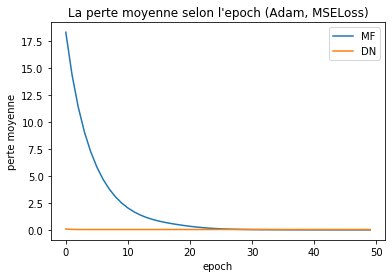

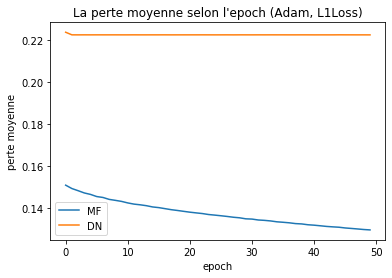

{'MatrixFacto_SGD_MSELoss': [3.9217080088693237, 3.07764855003953], 'MatrixFacto_SGD_L1Loss': [3.86157029292817, 3.0269195351488887], 'DN_SGD_MSELoss': [0.2884027649364175, 0.24198760321438312], 'DN_SGD_L1Loss': [0.310792134475935, 0.22747792307436465]}
{'MatrixFacto_Adam_MSELoss': [0.5921865061850121, 0.34930455486997963], 'MatrixFacto_Adam_L1Loss': [0.5579611647632268, 0.3390772651674226], 'DN_Adam_MSELoss': [0.28842422643919297, 0.24209600452780725], 'DN_Adam_L1Loss': [0.31092924143450223, 0.2275293593287468]}


In [37]:
import math
import copy

n_epochs = len(avg_losses["MatrixFacto_SGD_MSELoss"])
x_s = [i for i in range(n_epochs)]
show_plots(avg_losses_adam["MatrixFacto_Adam_MSELoss"], avg_losses_adam["DN_Adam_MSELoss"], x_s, ["epoch", "perte moyenne", "La perte moyenne selon l'epoch (Adam, MSELoss)"])
show_plots(avg_losses_adam["MatrixFacto_Adam_L1Loss"], avg_losses_adam["DN_Adam_L1Loss"], x_s, ["epoch", "perte moyenne", "La perte moyenne selon l'epoch (Adam, L1Loss)"])
new_metrics = copy.deepcopy(metrics)
new_metrics_adam = copy.deepcopy(metrics_adam)
for k in new_metrics:
    new_metrics[k][0] = math.sqrt(new_metrics[k][0])
for k in new_metrics_adam:
    new_metrics_adam[k][0] = math.sqrt(new_metrics_adam[k][0])
print(new_metrics)
print(new_metrics_adam)

In [42]:
from time import process_time

n_factors = [10, 20, 30]
loss_func = nn.L1Loss()
batch_size = 128

n_epochs = [10, 30, 50]
times = {}
metrics_e_l = {}
for e in n_epochs:
    for f in n_factors:
        model_mf = MatrixFacto(n_users, n_items, f)
        model_mf.cuda()
        optimizer_mf = Adam(model_mf.parameters(), lr=0.001)
        t1 = process_time()
        avg_losses_mf, _ = train(e, train_data, batch_size, optimizer_mf, loss_func, model_mf)
        times["MF_Adam_L1" + str(e) + "_" + str(f)] = process_time() - t1
        test_pred_mf = evaluate(model_mf, test_data)
        metrics_e_l["MF_Adam_L1" + str(e) + "_" + str(f)] = [math.sqrt(mean_squared_error(test_pred_mf.cpu().numpy(), test_data["rating"].values)), 
                   mean_absolute_error(test_pred_mf.cpu().numpy(), test_data["rating"].values)]
        
        model_dn = DN(n_users, n_items, f)
        model_dn.cuda()
        optimizer_dn = SGD(model_dn.parameters(), lr=0.001)
        t1 = process_time()
        avg_losses_dn, _ = train(e, train_data, batch_size, optimizer_dn, loss_func, model_dn)
        times["DN_SGD_L1" + str(e) + "_" + str(f)] = process_time() - t1
        test_pred_dn = evaluate(model_dn, test_data)
        metrics_e_l["DN_SGD_L1" + str(e) + "_" + str(f)] = [math.sqrt(mean_squared_error(test_pred_dn.cpu().numpy(), test_data["rating"].values)), 
                   mean_absolute_error(test_pred_dn.cpu().numpy(), test_data["rating"].values)]

epoch 0 : 2.3532679082870485
epoch 1 : 2.0285055263519287
epoch 2 : 1.7517619049072266
epoch 3 : 1.5200186256408692
epoch 4 : 1.3282728338241576
epoch 5 : 1.1717613259315491
epoch 6 : 1.0457688935279845
epoch 7 : 0.9451094311714172
epoch 8 : 0.8645891944885253
epoch 9 : 0.7986183426856994
[-0.14054292  0.9662505   1.2822028  ... -3.0927534  -1.4036496
  0.47507396]


C:\Users\sajsa\anaconda3\lib\site-packages\torch\nn\modules\loss.py:88: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


epoch 0 : 0.569557444524765
epoch 1 : 0.28219291002750396
epoch 2 : 0.2461203859090805
epoch 3 : 0.23944840149879457
epoch 4 : 0.23540854053497315
epoch 5 : 0.2326290789604187
epoch 6 : 0.23054633553028106
epoch 7 : 0.22911849999427794
epoch 8 : 0.22806983199119568
epoch 9 : 0.22721655330657958
[[0.7310696 ]
 [0.719586  ]
 [0.72988665]
 ...
 [0.7367393 ]
 [0.7305653 ]
 [0.72841185]]
epoch 0 : 3.441813327407837
epoch 1 : 3.042049879837036
epoch 2 : 2.686246572113037
epoch 3 : 2.3719406894683837
epoch 4 : 2.0953395797729493
epoch 5 : 1.8526949365615846
epoch 6 : 1.6414245964050294
epoch 7 : 1.4592802415847779
epoch 8 : 1.3035843821525575
epoch 9 : 1.1717767934799195
[-1.7183961  -1.5562508   1.4265442  ...  3.6195183  -0.41510916
  3.2179258 ]


C:\Users\sajsa\anaconda3\lib\site-packages\torch\nn\modules\loss.py:88: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


epoch 0 : 0.3633001245498657
epoch 1 : 0.2814821140050888
epoch 2 : 0.26132967066764834
epoch 3 : 0.2497469366312027
epoch 4 : 0.24385792944431306
epoch 5 : 0.24069628708362578
epoch 6 : 0.2385522578239441
epoch 7 : 0.23684362587928773
epoch 8 : 0.23545848803520203
epoch 9 : 0.23426035256385802
[[0.65094376]
 [0.69226366]
 [0.67615795]
 ...
 [0.63618314]
 [0.69206446]
 [0.6471809 ]]
epoch 0 : 4.117683324432373
epoch 1 : 3.6719522567749023
epoch 2 : 3.2732829921722413
epoch 3 : 2.9183723083496096
epoch 4 : 2.602628797149658
epoch 5 : 2.3218616603851316
epoch 6 : 2.0729869728088377
epoch 7 : 1.8526558261871338
epoch 8 : 1.6582806777954102
epoch 9 : 1.4878270671844482
[ 7.814149   -0.57959414 -2.6317832  ... -2.1768312  -4.9825177
  1.4294105 ]


C:\Users\sajsa\anaconda3\lib\site-packages\torch\nn\modules\loss.py:88: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


epoch 0 : 0.3068017133712769
epoch 1 : 0.2605135987043381
epoch 2 : 0.249848513174057
epoch 3 : 0.24409445927143097
epoch 4 : 0.24066968636512756
epoch 5 : 0.2385716139793396
epoch 6 : 0.23672765851020813
epoch 7 : 0.23537051532268524
epoch 8 : 0.23402030448913574
epoch 9 : 0.2328760910987854
[[0.6778888 ]
 [0.67105204]
 [0.67877704]
 ...
 [0.6583581 ]
 [0.7206274 ]
 [0.6955311 ]]
epoch 0 : 2.3171188606262207
epoch 1 : 1.996580200958252
epoch 2 : 1.7240561010360718
epoch 3 : 1.4960168363571167
epoch 4 : 1.3078707323074341
epoch 5 : 1.1555185695648194
epoch 6 : 1.0338142922401428
epoch 7 : 0.9376716798782349
epoch 8 : 0.8619216427803039
epoch 9 : 0.8014102156639099
epoch 10 : 0.7519158632278442
epoch 11 : 0.7092241046905517
epoch 12 : 0.669101374912262
epoch 13 : 0.6265896564960479
epoch 14 : 0.5763210515975952
epoch 15 : 0.5164489581108094
epoch 16 : 0.4522381429195404
epoch 17 : 0.3933082423686981
epoch 18 : 0.3452293432712555
epoch 19 : 0.3076096885442734
epoch 20 : 0.278429842734336

C:\Users\sajsa\anaconda3\lib\site-packages\torch\nn\modules\loss.py:88: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


epoch 0 : 0.3621209463119507
epoch 1 : 0.24949246563911437
epoch 2 : 0.2414966248035431
epoch 3 : 0.23823806047439575
epoch 4 : 0.23607389466762543
epoch 5 : 0.2345341665506363
epoch 6 : 0.23299673879146576
epoch 7 : 0.2317382521867752
epoch 8 : 0.23081012024879455
epoch 9 : 0.22974628851413728
epoch 10 : 0.22889577927589416
epoch 11 : 0.22811459670066833
epoch 12 : 0.2273823634147644
epoch 13 : 0.2267912252664566
epoch 14 : 0.22621073639392852
epoch 15 : 0.22572194402217866
epoch 16 : 0.22522360732555388
epoch 17 : 0.2248092371940613
epoch 18 : 0.22451218996047972
epoch 19 : 0.2242801147222519
epoch 20 : 0.2240717039346695
epoch 21 : 0.22388209416866303
epoch 22 : 0.22367844264507294
epoch 23 : 0.22353349001407624
epoch 24 : 0.22338847115039825
epoch 25 : 0.22333500463962555
epoch 26 : 0.22327422025203705
epoch 27 : 0.22321294281482695
epoch 28 : 0.22316173932552338
epoch 29 : 0.22314031841754914
[[0.749868  ]
 [0.74987555]
 [0.7498745 ]
 ...
 [0.74987346]
 [0.7498784 ]
 [0.7498686 ]]

C:\Users\sajsa\anaconda3\lib\site-packages\torch\nn\modules\loss.py:88: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


epoch 0 : 0.3619090999364853
epoch 1 : 0.25458299663066863
epoch 2 : 0.24547721855640411
epoch 3 : 0.2413262476682663
epoch 4 : 0.23877528619766236
epoch 5 : 0.2367586140871048
epoch 6 : 0.23495430171489715
epoch 7 : 0.23347095587253572
epoch 8 : 0.23219103367328645
epoch 9 : 0.2309188988685608
epoch 10 : 0.22972137362957
epoch 11 : 0.22867506003379823
epoch 12 : 0.22772456593513488
epoch 13 : 0.22685188121795655
epoch 14 : 0.22612397108078003
epoch 15 : 0.22543584632873534
epoch 16 : 0.22485332205295563
epoch 17 : 0.22436471266746522
epoch 18 : 0.22402769947052
epoch 19 : 0.22386088156700135
epoch 20 : 0.22371747975349426
epoch 21 : 0.22358711476325988
epoch 22 : 0.22345738048553468
epoch 23 : 0.22339576570987701
epoch 24 : 0.22332051033973693
epoch 25 : 0.22324468157291413
epoch 26 : 0.22318178298473357
epoch 27 : 0.22312647173404693
epoch 28 : 0.22308048450946807
epoch 29 : 0.22304695284366607
[[0.74965334]
 [0.7496481 ]
 [0.7496218 ]
 ...
 [0.74969894]
 [0.74968284]
 [0.7496786 ]]


C:\Users\sajsa\anaconda3\lib\site-packages\torch\nn\modules\loss.py:88: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


epoch 0 : 0.30041157240867616
epoch 1 : 0.2628925848722458
epoch 2 : 0.252678075838089
epoch 3 : 0.24656692266464234
epoch 4 : 0.24292338857650758
epoch 5 : 0.2406995166540146
epoch 6 : 0.2391055216550827
epoch 7 : 0.23781554291248322
epoch 8 : 0.23668727166652678
epoch 9 : 0.235629105591774
epoch 10 : 0.23463851232528687
epoch 11 : 0.23377573120594025
epoch 12 : 0.2328697205066681
epoch 13 : 0.23197945816516877
epoch 14 : 0.23123099451065063
epoch 15 : 0.2304493021249771
epoch 16 : 0.22970729365348816
epoch 17 : 0.22901645271778107
epoch 18 : 0.22842870552539826
epoch 19 : 0.2278050922393799
epoch 20 : 0.22724637649059296
epoch 21 : 0.22668149406909943
epoch 22 : 0.22616570799350738
epoch 23 : 0.22571072041988371
epoch 24 : 0.22528725428581237
epoch 25 : 0.22490594565868377
epoch 26 : 0.22454851179122925
epoch 27 : 0.2242684559583664
epoch 28 : 0.2240007699251175
epoch 29 : 0.22377827413082121
[[0.75386125]
 [0.75101006]
 [0.7462717 ]
 ...
 [0.7446215 ]
 [0.74652076]
 [0.7475557 ]]
ep

C:\Users\sajsa\anaconda3\lib\site-packages\torch\nn\modules\loss.py:88: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


epoch 0 : 0.5234305478572846
epoch 1 : 0.3108505819320679
epoch 2 : 0.2651412622690201
epoch 3 : 0.24816988940238952
epoch 4 : 0.24212219665050508
epoch 5 : 0.2386068614244461
epoch 6 : 0.23584922692775726
epoch 7 : 0.23346553134918213
epoch 8 : 0.23155908546447754
epoch 9 : 0.22973588075637819
epoch 10 : 0.22820895993709564
epoch 11 : 0.22693933651447296
epoch 12 : 0.2260749184846878
epoch 13 : 0.2256770301103592
epoch 14 : 0.22527811422348024
epoch 15 : 0.2249652181863785
epoch 16 : 0.224721457529068
epoch 17 : 0.22450175647735596
epoch 18 : 0.22428328392505645
epoch 19 : 0.22416382648944855
epoch 20 : 0.22399185376167297
epoch 21 : 0.22384294948577882
epoch 22 : 0.2237189736843109
epoch 23 : 0.2236430183172226
epoch 24 : 0.2235556892156601
epoch 25 : 0.22349612488746642
epoch 26 : 0.22342220118045808
epoch 27 : 0.22337714376449586
epoch 28 : 0.22332242691516876
epoch 29 : 0.22326947574615477
epoch 30 : 0.22324174258708954
epoch 31 : 0.22314740574359893
epoch 32 : 0.22313749730587007

C:\Users\sajsa\anaconda3\lib\site-packages\torch\nn\modules\loss.py:88: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


epoch 0 : 0.486606840467453
epoch 1 : 0.30041748275756835
epoch 2 : 0.26754584965705874
epoch 3 : 0.2518197122335434
epoch 4 : 0.2443888658285141
epoch 5 : 0.2406908292531967
epoch 6 : 0.23827873072624206
epoch 7 : 0.23627509799003601
epoch 8 : 0.23474010801315306
epoch 9 : 0.23317079780101777
epoch 10 : 0.231901544880867
epoch 11 : 0.2306211946964264
epoch 12 : 0.22942501187324524
epoch 13 : 0.22837121407985686
epoch 14 : 0.22741778135299684
epoch 15 : 0.22657495718002318
epoch 16 : 0.22593422224521637
epoch 17 : 0.22533531682491303
epoch 18 : 0.22484543421268463
epoch 19 : 0.22444321274757384
epoch 20 : 0.22413818747997283
epoch 21 : 0.22396452119350432
epoch 22 : 0.22377972555160522
epoch 23 : 0.22366798095703125
epoch 24 : 0.2235560433626175
epoch 25 : 0.22350212938785552
epoch 26 : 0.2234506241083145
epoch 27 : 0.22340496752262115
epoch 28 : 0.2233363292694092
epoch 29 : 0.223302161693573
epoch 30 : 0.22324808101654053
epoch 31 : 0.2232028689146042
epoch 32 : 0.2231584048986435
ep

C:\Users\sajsa\anaconda3\lib\site-packages\torch\nn\modules\loss.py:88: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


epoch 0 : 0.4312871654033661
epoch 1 : 0.26535090916156767
epoch 2 : 0.2527810113430023
epoch 3 : 0.2464243978738785
epoch 4 : 0.24258900809288025
epoch 5 : 0.24011814427375794
epoch 6 : 0.2383154060125351
epoch 7 : 0.23682705092430115
epoch 8 : 0.23559083983898163
epoch 9 : 0.2344885615348816
epoch 10 : 0.23338642444610597
epoch 11 : 0.23236875095367432
epoch 12 : 0.23144996745586396
epoch 13 : 0.23061561188697816
epoch 14 : 0.2298503945350647
epoch 15 : 0.2290913472175598
epoch 16 : 0.22831414966583252
epoch 17 : 0.22762349228858947
epoch 18 : 0.22697973160743715
epoch 19 : 0.22646531298160552
epoch 20 : 0.22593739488124848
epoch 21 : 0.22546668610572815
epoch 22 : 0.2250663186073303
epoch 23 : 0.22471660978794097
epoch 24 : 0.22444293599128723
epoch 25 : 0.22420388963222504
epoch 26 : 0.22402165944576263
epoch 27 : 0.22388658213615417
epoch 28 : 0.22378155286312104
epoch 29 : 0.22366274371147155
epoch 30 : 0.22354384891986848
epoch 31 : 0.22346290805339813
epoch 32 : 0.2233528605937

In [43]:
print(metrics_e_l)
print(times)

{'MF_Adam_L110_10': [1.2465441630132725, 0.9508738031747751], 'DN_SGD_L110_10': [0.30475144009760824, 0.2296769399702549], 'MF_Adam_L110_20': [2.0267923894721864, 1.5333809041680768], 'DN_SGD_L110_20': [0.29009132306781477, 0.23746891760528088], 'MF_Adam_L110_30': [2.8320354743149183, 2.1531438987959177], 'DN_SGD_L110_30': [0.29244658198698587, 0.2367205414891243], 'MF_Adam_L130_10': [0.4254574226668644, 0.2742562234473269], 'DN_SGD_L130_10': [0.3106858106640016, 0.2275124241858721], 'MF_Adam_L130_20': [0.8145842925685409, 0.4886871631555783], 'DN_SGD_L130_20': [0.3107575533154649, 0.22751151804327965], 'MF_Adam_L130_30': [1.3086796450348666, 0.8312914019875578], 'DN_SGD_L130_30': [0.30980112841944657, 0.22790857069790363], 'MF_Adam_L150_10': [0.3904453616984802, 0.2510979905397748], 'DN_SGD_L150_10': [0.3106456511196849, 0.2275249383598566], 'MF_Adam_L150_20': [0.6371302819110117, 0.3673823411445599], 'DN_SGD_L150_20': [0.3108158512917604, 0.227496409034729], 'MF_Adam_L150_30': [1.005